In [399]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [400]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [401]:
import bnn.functions
import bnn.loss
import bnn.network
import bnn.layer

In [402]:
dims = [32]*3 + [128]*3 + [1024]*10 + [128]*3 + [32]*10
dims = [8, 16, 32, 64, 64, 64, 32, 16, 8]
dims = [d*2 for d in dims]
TBNN = bnn.network.TernBinNetwork(*dims)

In [403]:
# assert integers
for p in TBNN.parameters():
    all_ints = True
    if torch.is_floating_point(p) or torch.is_complex(p):
        print(p.dtype)
        all_ints = False

assert all_ints

In [404]:
samples = 10

input = bnn.functions.binarise(torch.randn(samples, dims[0])).to(torch.int)
desired = bnn.functions.binarise(torch.randn(samples, dims[-1])).to(torch.int)

In [405]:
TBNN._initialise(W_mean=0.1, W_zero_prob=0.5)

In [406]:
output = TBNN.forward(input)
output.shape

torch.Size([10, 16])

In [407]:
loss = bnn.loss.number_incorrect.forward(output=output, target=desired)
loss

tensor(178)

In [408]:
grad = bnn.loss.number_incorrect.backward(output=output, target=desired)
grad.shape

torch.Size([10, 16])

In [409]:
out_grad = TBNN.backward(grad)
out_grad.shape

torch.Size([10, 16])

In [410]:
# check grads and Ws match
for layer in TBNN.layers.values():
    layer: bnn.layer.TernBinLayer
    assert layer.W.shape == layer.W.grad.shape

In [411]:
list(TBNN.layers.values())[len(dims)//2].W.grad

tensor([[ 7, -2,  0,  ...,  5,  4,  5],
        [ 1, -4, -6,  ...,  5,  2,  1],
        [ 3, -2, -2,  ...,  5,  2,  1],
        ...,
        [ 3, -2, -4,  ...,  5,  4,  1],
        [ 3, -2, -4,  ...,  7,  4,  3],
        [ 1, -2,  4,  ...,  1,  4,  1]], dtype=torch.int32)

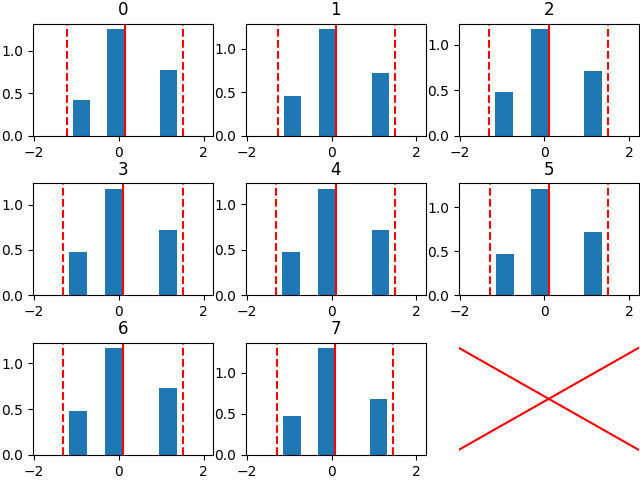

In [412]:
FIG_NAME = "W distribution"
plt.close(FIG_NAME)

data = [layer.W for layer in TBNN.layers.values()]
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.to(torch.float)
        mean = datum_float.mean().item()
        std = datum_float.std().item()

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-")
        ax.axvline(mean+2*std, color="red", ls="--")
        ax.axvline(mean-2*std, color="red", ls="--")


for ax in axs:
    ax.set_xlim(min_x, max_x)
        

fig.tight_layout(pad=0.1)

plt.show()

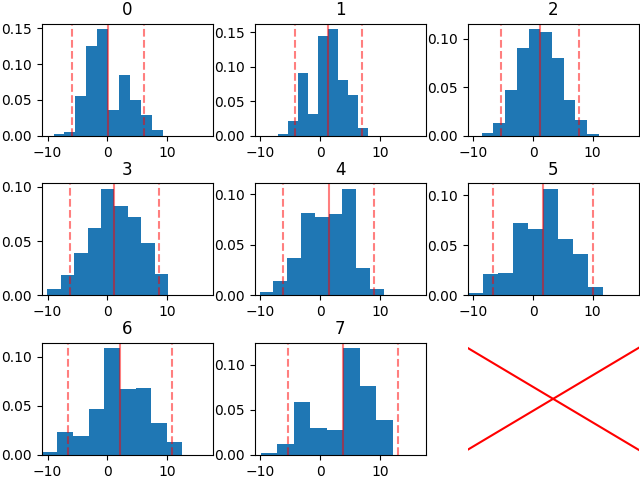

In [413]:
FIG_NAME = "W_grad distribution"
plt.close(FIG_NAME)

data = [layer.W.grad for layer in TBNN.layers.values()]
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.to(torch.float)
        mean = datum_float.mean().item()
        std = datum_float.std().item()

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-", alpha=0.5)
        ax.axvline(mean+2*std, color="red", ls="--", alpha=0.5)
        ax.axvline(mean-2*std, color="red", ls="--", alpha=0.5)


for ax in axs:
    ax.set_xlim(min_x, max_x)
        

fig.tight_layout(pad=0.1)

plt.show()

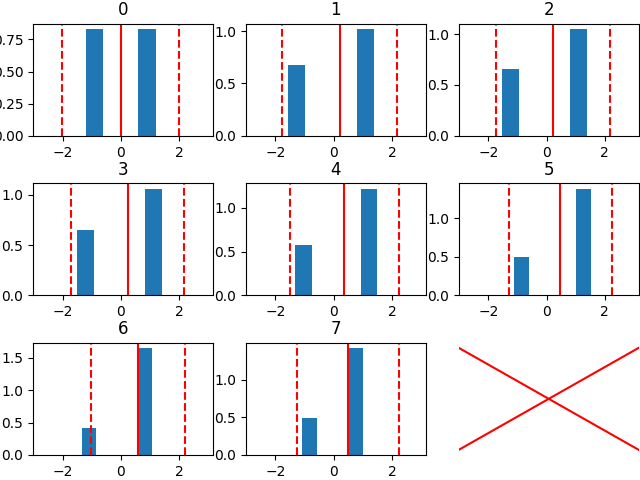

In [417]:
FIG_NAME = "activation distribution"
plt.close(FIG_NAME)

data = TBNN.input.values()
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.to(torch.float)
        mean = datum_float.mean().item()
        std = datum_float.std().item()

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-")
        ax.axvline(mean+2*std, color="red", ls="--")
        ax.axvline(mean-2*std, color="red", ls="--")


for ax in axs:
    ax.set_xlim(min_x, max_x)
        

fig.tight_layout(pad=0.1)

plt.show()

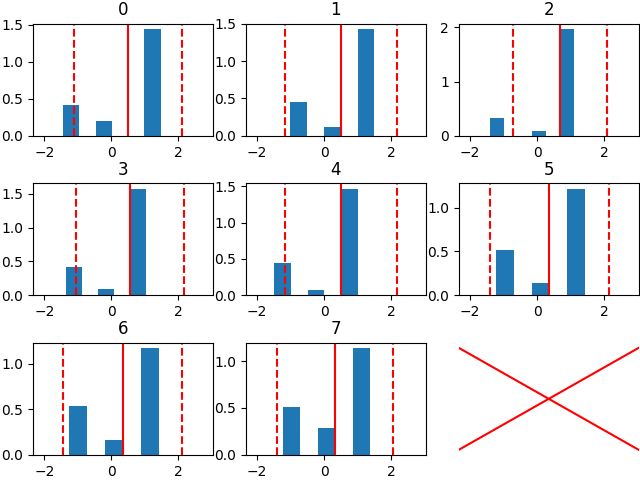

In [415]:
FIG_NAME = "grad distribution"
plt.close(FIG_NAME)

data = TBNN.grad.values()
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.to(torch.float)
        mean = datum_float.mean().item()
        std = datum_float.std().item()

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-")
        ax.axvline(mean+2*std, color="red", ls="--")
        ax.axvline(mean-2*std, color="red", ls="--")


for ax in axs:
    ax.set_xlim(min_x, max_x)
        

fig.tight_layout(pad=0.1)

plt.show()